In [1]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torchmodel import UNet
from root_dataset import Root_dataset
import albumentations as albu
import segmentation_models_pytorch as smp

/opt/homebrew/Caskroom/miniconda/base/envs/ptch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def get_train_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomRotate90(p=0.5),
        albu.Transpose(p=0.5),
        albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        albu.GridDistortion(p=0.5),
        albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.RandomGamma(p=0.5),
        albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
        albu.GaussNoise(),
        albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
        albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [4]:
def get_val_augmentation(height):
    trainaugmentation = albu.Compose([
        albu.Resize(height,height),
        albu.Lambda(image=lambda x,**kwargs: x/255),
    ])
    return trainaugmentation

In [5]:
train_aug = get_train_augmentation(512)
val_aug = get_val_augmentation(512)

/opt/homebrew/Caskroom/miniconda/base/envs/ptch/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1777: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn(


In [6]:
train = Root_dataset(train_aug,'crosval/train','castom-masks/masks_machine',device)
val = Root_dataset(val_aug,'crosval/val','castom-masks/masks_machine',device)

['AAE_0196.png', 'AAE_0182.png', 'AAE_0021.png', 'AAE_0236.png', 'AAE_0140.png', 'AAE_0154.png', 'AAE_0181.png', 'AAE_0156.png', 'AAE_0036.png', 'AAE_0022.png', 'AAE_0209.png', 'AAE_0180.png', 'AAE_0184.png', 'AAE_0190.png', 'AAE_0147.png', 'AAE_0027.png', 'AAE_0218.png', 'AAE_0146.png', 'AAE_0185.png', 'AAE_0193.png', 'AAE_0150.png', 'AAE_0226.png', 'AAE_0233.png', 'AAE_0019.png', 'AAE_0025.png', 'AAE_0179.png', 'AAE_0145.png', 'AAE_0192.png', 'AAE_0136.png', 'AAE_0057.png', 'AAE_0080.png', 'AAE_0041.png', 'AAE_0040.png', 'AAE_0068.png', 'AAE_0083.png', 'AAE_0097.png', 'AAE_0124.png', 'AAE_0087.png', 'AAE_0045.png', 'AAE_0119.png', 'AAE_0125.png', 'AAE_0127.png', 'AAE_0047.png', 'AAE_0085.png', 'AAE_0117.png', 'AAE_0063.png', 'AAE_0076.png', 'AAE_0062.png', 'AAE_0089.png', 'AAE_0116.png', 'AAE_0100.png', 'AAE_0114.png', 'AAE_0048.png', 'AAE_0101.png', 'AAE_0071.png', 'AAE_0058.png', 'AAE_0070.png', 'AAE_0073.png', 'AAE_0098.png', 'AAE_0107.png', 'AAE_0174.png', 'AAE_0028.png', 'AAE_00

<Figure size 640x480 with 0 Axes>

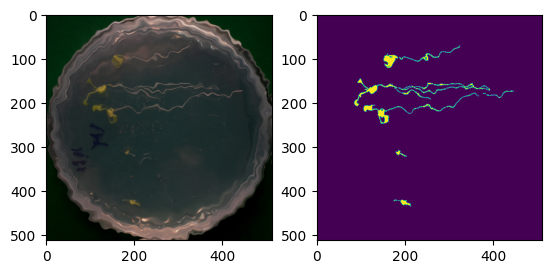

In [7]:
plt.figure()
f, axarr = plt.subplots(1,2) 
image,mask = train.__getitem__(0)
axarr[0].imshow(image.permute(1,2,0))
axarr[1].imshow(mask.permute(1,2,0))

In [8]:
model = UNet(3,1)

In [9]:
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=True)
val_loader = torch.utils.data.DataLoader(val, batch_size=1, shuffle=False)

In [10]:
loss_f = smp.losses.DiceLoss(smp.losses.BINARY_MODE)
optimizer = torch.optim.Adam(model.parameters(),0.001,amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2)

In [11]:
epochs = 20

In [12]:
model.to(device)
best_loss = 100
for epoch in range(epochs):
    train_loss = 0.0
    model.train()
    for inputs, targets in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_f(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    val_loss = 0.0

    model.eval()
    for inputs, targets in tqdm(val_loader):
        model.eval()
        outputs = model(inputs)
            
            # Calculate loss
        loss = loss_f(outputs, targets)
        val_loss += loss.item()

    val_loss /= len(val_loader)

    scheduler.step(val_loss)

    if val_loss < best_loss: 
        best_loss = val_loss
        torch.save(model, 'best-model.pt')

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        

100%|██████████| 31/31 [00:08<00:00,  3.85it/s]


Epoch [1/20] | Train Loss: 0.9798 | Val Loss: 0.9758


100%|██████████| 31/31 [00:08<00:00,  3.84it/s]


Epoch [2/20] | Train Loss: 0.9781 | Val Loss: 0.9744


100%|██████████| 31/31 [00:08<00:00,  3.86it/s]


Epoch [3/20] | Train Loss: 0.9779 | Val Loss: 0.9755


100%|██████████| 31/31 [00:08<00:00,  3.85it/s]


Epoch [4/20] | Train Loss: 0.9784 | Val Loss: 0.9741


100%|██████████| 31/31 [00:08<00:00,  3.85it/s]


Epoch [5/20] | Train Loss: 0.9780 | Val Loss: 0.9742


100%|██████████| 31/31 [00:08<00:00,  3.78it/s]


Epoch [6/20] | Train Loss: 0.9776 | Val Loss: 0.9737


100%|██████████| 31/31 [00:08<00:00,  3.79it/s]


Epoch [7/20] | Train Loss: 0.9771 | Val Loss: 0.9737


100%|██████████| 31/31 [00:08<00:00,  3.80it/s]


Epoch [8/20] | Train Loss: 0.9780 | Val Loss: 0.9743


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


Epoch [9/20] | Train Loss: 0.9778 | Val Loss: 0.9751


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


Epoch [10/20] | Train Loss: 0.9782 | Val Loss: 0.9748


100%|██████████| 31/31 [00:08<00:00,  3.82it/s]


Epoch [11/20] | Train Loss: 0.9775 | Val Loss: 0.9738


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


Epoch [12/20] | Train Loss: 0.9772 | Val Loss: 0.9739


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


Epoch [13/20] | Train Loss: 0.9772 | Val Loss: 0.9736


100%|██████████| 31/31 [00:08<00:00,  3.80it/s]


Epoch [14/20] | Train Loss: 0.9782 | Val Loss: 0.9738


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


Epoch [15/20] | Train Loss: 0.9777 | Val Loss: 0.9746


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


Epoch [16/20] | Train Loss: 0.9776 | Val Loss: 0.9742


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


Epoch [17/20] | Train Loss: 0.9779 | Val Loss: 0.9740


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]


Epoch [18/20] | Train Loss: 0.9771 | Val Loss: 0.9740


100%|██████████| 31/31 [00:08<00:00,  3.80it/s]


Epoch [19/20] | Train Loss: 0.9772 | Val Loss: 0.9746


100%|██████████| 31/31 [00:08<00:00,  3.81it/s]

Epoch [20/20] | Train Loss: 0.9772 | Val Loss: 0.9738


In [13]:
model = torch.load('best-model.pt')

Epoch [10/10] | Train Loss: 4.1113 | Val Loss: 3.9804

In [14]:
outputs
for inputs, targets in tqdm(val_loader):
    model.eval()
    outputs = model(inputs)

100%|██████████| 31/31 [00:08<00:00,  3.85it/s]


In [15]:
outputs.shape
outputs = outputs.reshape(1, 512, 512)

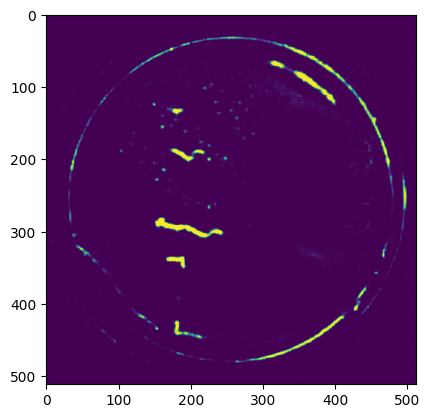

In [16]:
plt.imshow(outputs.permute(1,2,0).detach().numpy())